### Imports

In [1]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, Model
import keras as k

import sklearn
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

from keras.initializers import *

from matplotlib import pyplot as plt
import seaborn as sns
import scipy

from datetime import datetime

import pickle

from PIL import Image

from custom_class import *

print(f"pd.__version__: {pd.__version__}")
print(f"tf.__version__: {tf.__version__}")

2025-03-01 00:45:14.832826: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-01 00:45:14.878177: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-01 00:45:14.878208: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-01 00:45:14.879413: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-01 00:45:14.887148: I tensorflow/core/platform/cpu_feature_guar

pd.__version__: 2.2.3
tf.__version__: 2.15.1


### Read file path and labels to list

In [2]:
dataset_dir = "/mnt/c/Users/psamt/OneDrive - The University of Nottingham/_Spring/PHYS4036_Machine Learning in Science Part II/Project/Dataset/machine-learning-in-science-ii-2025"
# dataset_dir = "/kaggle/input/machine-learning-in-science-ii-2025"

csv_path = os.path.join(dataset_dir, "4200_encoded_labels_20250301_0007.csv")
csv_df = pd.read_csv(csv_path, index_col="image_id")

training_data_dir = os.path.join(dataset_dir, "training_data", "training_data")

# # there is one speed > 1. So change it.
# csv_df.loc[csv_df["speed"] > 1, "speed"] = 1

csv_df.drop(columns=["red_light", "green_light"], inplace=True)

csv_path = os.path.join(dataset_dir, "training_norm.csv")
training_norm_df = pd.read_csv(csv_path, index_col="image_id")

csv_df = csv_df.join(training_norm_df)
csv_df.drop(columns=['angle', 'obj_on_road_cont'], inplace=True)

display(csv_df)

,obj_off_road,obj_on_road_stop,speed
image_id,,,
1,0,1,0.0
2,0,0,1.0
3,0,0,1.0
4,0,0,1.0
5,0,1,0.0
...,...,...,...
4196,0,1,0.0
4197,0,0,1.0
4198,0,0,1.0


In [3]:
normal = ((csv_df['obj_off_road'] == 0) & (csv_df['obj_on_road_stop'] == 0))
csv_df['normal'] = normal.astype(int)
csv_df = csv_df.loc[:, ['normal', 'obj_on_road_stop', 'obj_off_road', 'speed']]

display(csv_df)

,normal,obj_on_road_stop,obj_off_road,speed
image_id,,,,
1,0,1,0,0.0
2,1,0,0,1.0
3,1,0,0,1.0
4,1,0,0,1.0
5,0,1,0,0.0
...,...,...,...,...
4196,0,1,0,0.0
4197,1,0,0,1.0
4198,1,0,0,1.0


Check the data

In [4]:
print(len(csv_df))
print(sum(csv_df['obj_on_road_stop']))
print(sum(csv_df['obj_off_road']))
print(sum(csv_df['normal']))

4198
929
243
3027


In [5]:
# obj_on_road_stop_index = csv_df[csv_df['obj_on_road_stop'] == 1].index
# obj_off_road_index = csv_df[csv_df['obj_off_road'] == 1].index
# normal_index = csv_df[((csv_df['obj_off_road'] == 0) & (csv_df['obj_on_road_stop'] == 0))].index

# obj_on_road_stop_weight = len(csv_df) / len(obj_on_road_stop_index)
# obj_off_road_weight = len(csv_df) / len(obj_off_road_index)
# normal_weight = len(csv_df) / len(normal_index)

# print(obj_on_road_stop_weight, obj_off_road_weight, normal_weight)

# weight_sum = obj_on_road_stop_weight +  obj_off_road_weight + normal_weight

# obj_on_road_stop_weight /= weight_sum
# obj_off_road_weight /= weight_sum
# normal_weight /= weight_sum

# print(obj_off_road_weight, obj_on_road_stop_weight, normal_weight)

In [6]:
image_id_list = list(csv_df.index)
train_index, test_index = train_test_split(image_id_list, test_size=0.2)
random_seed = 0

In [7]:
random_seed = 17
print(f"random_seed: {random_seed}")

train_index, test_index = train_test_split(image_id_list, test_size=0.2, random_state=random_seed)
train_df = csv_df.loc[train_index]
test_df = csv_df.loc[test_index]

train_off_road = train_df[train_df['obj_off_road'] == 1].index
train_on_road_stop = train_df[train_df['obj_on_road_stop'] == 1].index
train_normal = train_df[((train_df['obj_off_road'] == 0) & (train_df['obj_on_road_stop'] == 0))].index

print("Train ratio: ", end="")
print(len(train_normal)/len(train_df), len(train_on_road_stop)/len(train_df), len(train_off_road)/len(train_df))

test_off_road = test_df[test_df['obj_off_road'] == 1].index
test_on_road_stop = test_df[test_df['obj_on_road_stop'] == 1].index
test_normal = test_df[((test_df['obj_off_road'] == 0) & (test_df['obj_on_road_stop'] == 0))].index

print("Test ratio: ", end="")
print(len(test_normal)/len(test_df), len(test_on_road_stop)/len(test_df), len(test_off_road)/len(test_df))

MAX_MUL = 6

normal_weight = len(train_df) / len(train_normal)
obj_on_road_stop_weight = len(train_df) / len(train_on_road_stop)
obj_off_road_weight = len(train_df) / len(train_off_road)

obj_on_road_stop_weight /= normal_weight
obj_off_road_weight /= normal_weight
normal_weight /= normal_weight

obj_off_road_weight = min(obj_off_road_weight, MAX_MUL)


print("Proposed ratio: ", end="")
print(normal_weight, obj_on_road_stop_weight, obj_off_road_weight)


total_weight = (obj_off_road_weight + obj_on_road_stop_weight + normal_weight)

obj_off_road_weight /= total_weight
obj_on_road_stop_weight /= total_weight
normal_weight /= total_weight

print(len(train_normal), len(train_on_road_stop), len(train_off_road))
print(len(test_normal), len(test_on_road_stop), len(test_off_road))

print(len(train_normal)/len(train_df), len(train_on_road_stop)/len(train_df), len(train_off_road)/len(train_df))
print(len(test_normal)/len(test_df), len(test_on_road_stop)/len(test_df), len(test_off_road)/len(test_df))

print("Normalised proposed ratio: ", end="")
print(normal_weight, obj_on_road_stop_weight, obj_off_road_weight)

random_seed: 17
Train ratio: 0.7167957117331745 0.22394282310899344 0.05955926146515783
Test ratio: 0.7380952380952381 0.21071428571428572 0.05119047619047619
Proposed ratio: 1.0 3.2007978723404253 6
2407 752 200
620 177 43
0.7167957117331745 0.22394282310899344 0.05955926146515783
0.7380952380952381 0.21071428571428572 0.05119047619047619
Normalised proposed ratio: 0.09803154738625994 0.3137791682961804 0.5881892843175597


In [8]:
# over sampling the training set
p_for_over_sampling = []

for i in range(len(train_df)):
    if train_df.iloc[i]["obj_on_road_stop"] == 1:
        p_for_over_sampling.append(obj_on_road_stop_weight)
    elif train_df.iloc[i]["obj_off_road"] == 1:
        p_for_over_sampling.append(obj_off_road_weight)
    else:
        p_for_over_sampling.append(normal_weight)

p_for_over_sampling = np.array(p_for_over_sampling) / sum(p_for_over_sampling)

display(train_df)
print(p_for_over_sampling)

,normal,obj_on_road_stop,obj_off_road,speed
image_id,,,,
3545,0,1,0,0.0
2524,1,0,0,1.0
497,1,0,0,1.0
115,1,0,0,0.0
2779,1,0,0,1.0
...,...,...,...,...
2801,1,0,0,1.0
1338,1,0,0,1.0
407,1,0,0,1.0


[0.00053276 0.00016644 0.00016644 ... 0.00016644 0.00016644 0.00053276]


In [9]:
train_index
train_label = []
for i in range(len(train_index)):
    if train_index[i] in train_on_road_stop:
        train_label.append(1)
    elif train_index[i] in train_off_road:
        train_label.append(2)
    else:
        train_label.append(0)

train_label = np.array(train_label)

test_index
test_label = []
for i in range(len(test_index)):
    if test_index[i] in test_on_road_stop:
        test_label.append(1)
    elif test_index[i] in test_off_road:
        test_label.append(2)
    else:
        test_label.append(0)

test_label = np.array(test_label)

train_label

array([1, 0, 0, ..., 0, 0, 1])

In [10]:
sample_probs_tensor = tf.constant(p_for_over_sampling, dtype=tf.float32)

X_train_tensor = tf.constant(train_index, dtype=tf.int32)
y_train_tensor = tf.constant(train_label, dtype=tf.int32)

NUM_SAMPLES = 1000

def sample_indices():
    return tf.random.categorical(tf.math.log([sample_probs_tensor]), NUM_SAMPLES)[0]

sampled_indices = sample_indices()

X_train_os = tf.gather(X_train_tensor, sampled_indices)
y_train_os = tf.gather(y_train_tensor, sampled_indices)

train_ds = tf.data.Dataset.from_tensor_slices((X_train_os, y_train_os))

2025-03-01 00:45:17.915227: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-01 00:45:17.951382: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-01 00:45:17.951431: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-01 00:45:17.955117: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-01 00:45:17.955164: I external/local_xla/xla/stream_executor

In [11]:
labels = []
for X, y in train_ds:
  labels.append(y.numpy())

y_count = pd.Series(labels).value_counts().sort_index()
print(y_count)

0    419
1    371
2    210
Name: count, dtype: int64


In [12]:
train_ds
val_ds = tf.data.Dataset.from_tensor_slices((test_index, test_label))

In [13]:
def image_id_to_path(image_id, label):
    image_path = tf.strings.join([training_data_dir, '/', tf.as_string(image_id), ".png"])  # Assuming images are .jpg
    return image_path, label

train_ds = train_ds.map(image_id_to_path)
val_ds = val_ds.map(image_id_to_path)

In [14]:
def decode_img(
    img,
):  # -> Any | defaultdict | Any | list | None | object | Tensor | ...:
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

def process_path(file_path, label):
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

train_ds = train_ds.map(process_path)
val_ds = val_ds.map(process_path)

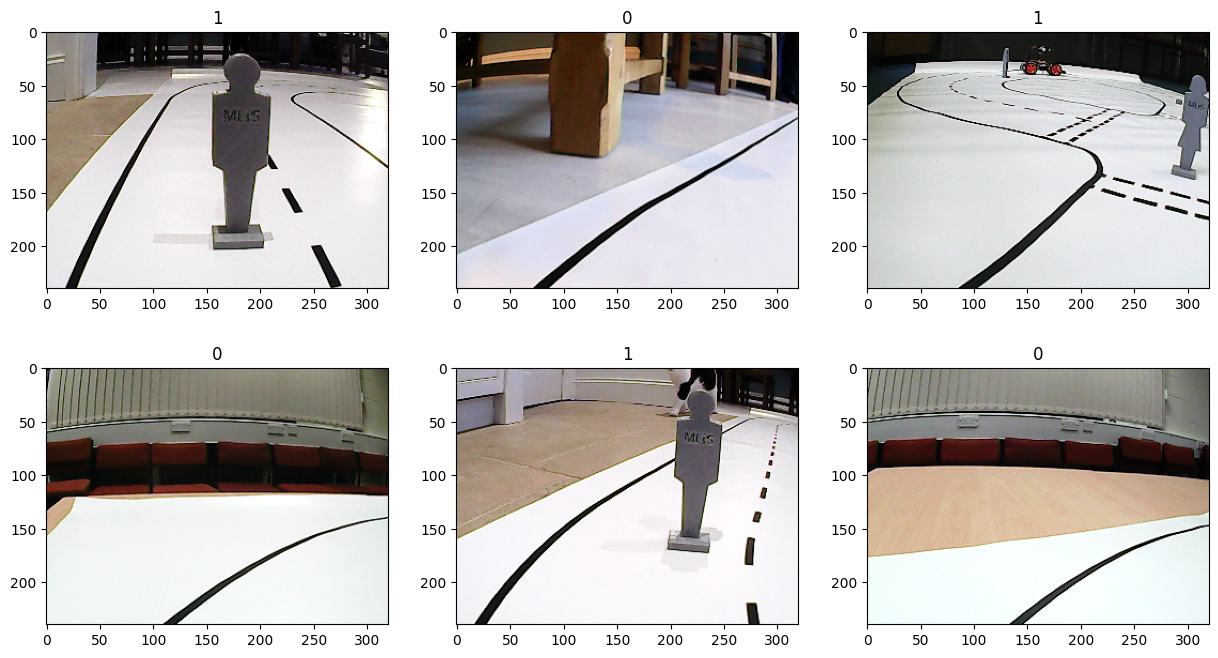

In [15]:
fig, ax = plt.subplots(2, 3, figsize=(15, 8))
ax = ax.ravel()

i = 0

for image, label in train_ds.take(6):
    ax[i].imshow(image.numpy())
    ax[i].set_title(label.numpy())
    i += 1

In [16]:
train_ds_length = tf.data.experimental.cardinality(train_ds).numpy()
print(train_ds_length)
val_ds_length = tf.data.experimental.cardinality(val_ds).numpy()
print(val_ds_length)

1000
840


In [17]:
def visualise(original, augmented):
    fig = plt.figure()
    plt.subplot(1, 2, 1)
    plt.title("Original image")
    plt.imshow(original.numpy().astype("float32"))

    plt.subplot(1, 2, 2)
    plt.title("Augmented image")
    plt.imshow(augmented.numpy().astype("float32"))

In [18]:
rotate_by_degree = 5
random_rotate = keras.layers.RandomRotation(rotate_by_degree / 360)


def augment(image, label, seed=None):
    # Deal with the random seed
    if seed == None:
        seed = tf.random.uniform(shape=[2], maxval=10000, dtype=tf.int32)
    else:
        seed = tf.constant([seed, seed], dtype=tf.int32)

    image = tf.image.stateless_random_brightness(image, 0.3, seed)
    image = tf.image.stateless_random_contrast(image, 0.75, 1.25, seed)
    image = tf.image.stateless_random_hue(image, 0.05, seed)
    image = tf.image.stateless_random_saturation(image, 0.7, 1.2, seed)
    image = tf.image.stateless_random_jpeg_quality(image, 80, 100, seed)

    image = random_rotate(image)

    # crop image
    image = tf.image.stateless_random_crop(image, size=[210, 280, 3], seed=seed)

    # resize image back to 240x320
    image = tf.image.resize(image, [240, 320])

    return image, label

Test augment function

20
Augmented image shape: (240, 320, 3)


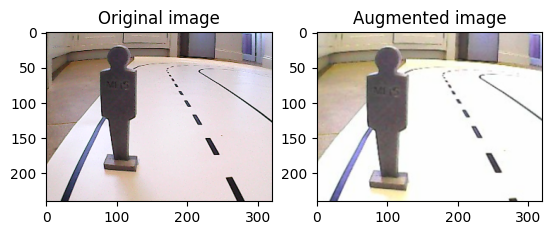

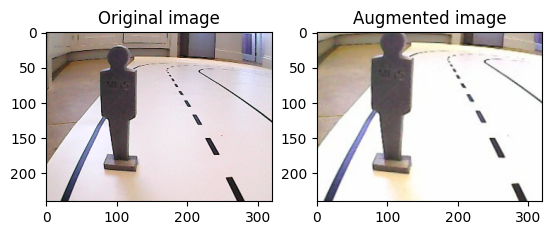

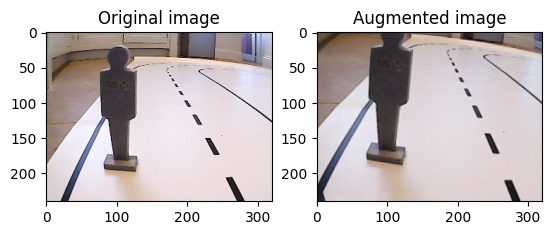

In [19]:
skip = 20
# skip+=1
print(skip)
for i in range(3):
    for image, label in train_ds.skip(skip).take(1):
        augmented_image, label = augment(image, label, None)
        visualise(image, augmented_image)

for image, label in train_ds.take(1):
    aug_image, aug_speed = augment(image, label)
    print(f"Augmented image shape: {aug_image.shape}")

In [20]:
train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

In [21]:
def scale_ds(image, label):
    # Range of input image: [0, 1]
    return image * 2 - 1.0, label


train_ds = train_ds.map(scale_ds, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(scale_ds, num_parallel_calls=tf.data.AUTOTUNE)

In [22]:
def rephrase_ds(image, label):
    labels = tf.one_hot(label, depth=3)
    return image, labels

train_ds = train_ds.map(rephrase_ds, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(rephrase_ds, num_parallel_calls=tf.data.AUTOTUNE)

In [23]:
for image, label in train_ds.take(1):
  print(label.numpy())

[0. 1. 0.]


In [24]:
batch_size = 32


def configure_for_performance(ds, shuffle: bool, batch: bool):
    if shuffle:
        ds = ds.shuffle(buffer_size=3000)
    if batch:
        ds = ds.batch(batch_size, drop_remainder=True)
    else:
        ds = ds.batch(1, drop_remainder=False)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds


train_ds = train_ds.repeat()
val_ds = val_ds.repeat()
train_ds = configure_for_performance(train_ds, shuffle=True, batch=True)
val_ds = configure_for_performance(val_ds, shuffle=False, batch=True)

### Build model

In [25]:
image_shape = (240, 320, 3)

base_model = keras.applications.MobileNetV3Large(
    include_top=False,
    weights="imagenet",
    input_shape=image_shape,
    pooling=None,
    include_preprocessing=False, 
)
base_model.trainable = False

print(base_model.output.shape)

(None, 8, 10, 960)


In [26]:
feature_extractor = base_model.output

print(feature_extractor.shape)

x = layers.Conv2D(42, (3, 3), (2, 2), activation='relu', 
                  kernel_initializer=HeUniform(), padding='same', name='speed_conv_1')(feature_extractor)
x = layers.Flatten()(x)
# x = layers.Dense(512, activation='relu', kernel_initializer=HeUniform(), name='speed_dense_2')(x)
# x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu', kernel_initializer=HeUniform(), name='speed_dense_1')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(3, activation='softmax', name='speed_dense_0')(x)

speed_output = x

model = Model(inputs=base_model.input, outputs={'speed_output': speed_output}, name="my_model")

learning_rate = 0.0010

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    # loss={"speed_output": "mse"},
    loss={"speed_output": 'categorical_crossentropy'},
    metrics={"speed_output": ["mse", "accuracy"]},
)

# model.summary()

(None, 8, 10, 960)


In [27]:
sub_model = Model(feature_extractor, speed_output)
tf.keras.utils.plot_model(
    sub_model,
    show_shapes=True,  # Show input/output shapes
    show_layer_names=True,  # Show layer names (e.g., "angle_hidden_2")
    expand_nested=False,  # Keep it flat (no base_model nesting)
    show_layer_activations=True,
    dpi=96,  # Image resolution
)

print("Saved model image: model.png")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Saved model image: model.png


In [28]:
current_epoch = 1
def get_current_epoch():
    return current_epoch

In [29]:
def lr_schedule(epoch, lr):
    FIRST_N_EPOCHS = 5
    epoch = current_epoch-1
    
    initial_lr = learning_rate
    if epoch < FIRST_N_EPOCHS:
        return max(initial_lr * 2, 0.002)
    decay = 0.3
    return initial_lr / (1 + ((epoch-FIRST_N_EPOCHS) // 3) * decay)

for epoch in range(30):
    current_epoch = epoch + 1
    print(f"Epoch {epoch+1:2d}: {lr_schedule(epoch, 0):.6f}")

current_epoch = 1

Epoch  1: 0.002000
Epoch  2: 0.002000
Epoch  3: 0.002000
Epoch  4: 0.002000
Epoch  5: 0.002000
Epoch  6: 0.001000
Epoch  7: 0.001000
Epoch  8: 0.001000
Epoch  9: 0.000769
Epoch 10: 0.000769
Epoch 11: 0.000769
Epoch 12: 0.000625
Epoch 13: 0.000625
Epoch 14: 0.000625
Epoch 15: 0.000526
Epoch 16: 0.000526
Epoch 17: 0.000526
Epoch 18: 0.000455
Epoch 19: 0.000455
Epoch 20: 0.000455
Epoch 21: 0.000400
Epoch 22: 0.000400
Epoch 23: 0.000400
Epoch 24: 0.000357
Epoch 25: 0.000357
Epoch 26: 0.000357
Epoch 27: 0.000323
Epoch 28: 0.000323
Epoch 29: 0.000323
Epoch 30: 0.000294


In [30]:
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=f"checkpoints/model_epoch_{current_epoch:02d}.keras",
    save_weights_only=False,
    save_freq="epoch",
    verbose=1,
)

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1)

history_callback = keras.callbacks.History()

### Train model

In [31]:
NUM_OF_EPOCHS = 50

current_epoch = 1

try:
    for i in range(NUM_OF_EPOCHS):
        print(f"\n{50*'*'}\nCurrent epoch: {current_epoch}", end="")
        
        sampled_indices = sample_indices()

        X_train_os = tf.gather(X_train_tensor, sampled_indices)
        y_train_os = tf.gather(y_train_tensor, sampled_indices)
        train_ds = tf.data.Dataset.from_tensor_slices((X_train_os, y_train_os))
        train_ds = train_ds.map(image_id_to_path)
        train_ds = train_ds.map(process_path)
        train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
        train_ds = train_ds.map(scale_ds, num_parallel_calls=tf.data.AUTOTUNE)
        train_ds = train_ds.map(rephrase_ds, num_parallel_calls=tf.data.AUTOTUNE)
        train_ds = train_ds.repeat()
        train_ds = configure_for_performance(train_ds, shuffle=True, batch=True)

        
        model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=1,
            steps_per_epoch=train_ds_length // batch_size,
            validation_steps=val_ds_length // batch_size,
            callbacks=[checkpoint, history_callback, lr_scheduler],
            verbose=1,
        )
        current_epoch += 1

except KeyboardInterrupt:
    print("Stopped early—saving history")
    with open("training_history.pkl", "wb") as f:
        pickle.dump(history_callback.history, f)

# try:
#     history = model.fit(
#         train_ds,
#         validation_data=val_ds,
#         epochs=NUM_OF_EPOCHS,
#         steps_per_epoch= train_ds_length // batch_size,
#         validation_steps= val_ds_length // batch_size,
#         callbacks=[checkpoint, history_callback, lr_scheduler],
#         verbose=1,
#     )
# except KeyboardInterrupt:
#     print("Stopped early—saving history")
#     with open("training_history.pkl", "wb") as f:
#         pickle.dump(history_callback.history, f)


**************************************************
Current epoch: 1


Epoch 1: LearningRateScheduler setting learning rate to 0.002.


2025-03-01 00:45:29.457225: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2025-03-01 00:45:29.615344: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-03-01 00:45:33.411536: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fae9e49f390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-01 00:45:33.411589: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2025-03-01 00:45:33.418576: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740789933.493167  122869 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


30/31 [============================>.] - ETA: 0s - loss: 0.7451 - mse: 0.1149 - accuracy: 0.7812
Epoch 1: saving model to checkpoints/model_epoch_01.keras
31/31 [==============================] - 16s 140ms/step - loss: 0.7285 - mse: 0.1126 - accuracy: 0.7853 - val_loss: 0.3251 - val_mse: 0.0564 - val_accuracy: 0.8834 - lr: 0.0020

**************************************************
Current epoch: 2
Epoch 1: LearningRateScheduler setting learning rate to 0.002.
30/31 [============================>.] - ETA: 0s - loss: 0.3424 - mse: 0.0592 - accuracy: 0.8792
Epoch 1: saving model to checkpoints/model_epoch_01.keras
31/31 [==============================] - 9s 109ms/step - loss: 0.3358 - mse: 0.0583 - accuracy: 0.8810 - val_loss: 0.3708 - val_mse: 0.0605 - val_accuracy: 0.8774 - lr: 0.0020

**************************************************
Current epoch: 3
Epoch 1: LearningRateScheduler setting learning rate to 0.002.
30/31 [============================>.] - ETA: 0s - loss: 0.2578 - mse: 0.

### Save model and plot

In [32]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M")  # Format: YYYYMMDD_HHMM
name_template = f'speed_model_{timestamp}'

folder_path = f"Models/{name_template}"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

filename = f"{folder_path}/{name_template}.keras"
model.save(filename)
filename = f"{folder_path}/{name_template}.weights.h5"
model.save_weights(filename)

history = history_callback.history

filename = f"{folder_path}/{name_template}_history.pkl"
with open(filename, 'wb') as f:
    pickle.dump(history, f)

['loss', 'mse', 'accuracy', 'val_loss', 'val_mse', 'val_accuracy']


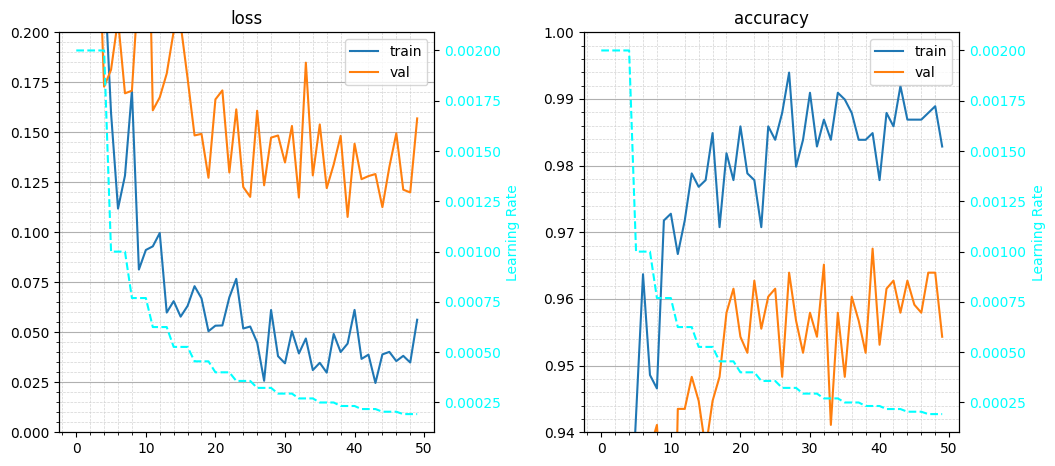

In [33]:
history = history_callback.history
history_1 = history_callback.history

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plt.subplots_adjust(left=0.1, right=0.85, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)


ax = ax.ravel()

keys = list(history.keys())
print(keys)
needed = [0, 2]
groups = [keys[i] for i in needed]

for key in history.keys():
    for j in range(len(groups)):
        if key.endswith(groups[j]):
            label = "val" if key.startswith("val") else "train"
            ax[j].plot(history[key], label=label)
            ax[j].set_title(groups[j])
            ax[j].minorticks_on()
            ax[j].grid(True, axis="y")
            ax[j].grid(which='minor', linestyle='--', linewidth=0.5, color='lightgray')
            ax[j].legend()
            break

ylim_list = [
    (0, 0.2),
    (0.94, 1),
]
for i in range(len(groups)):
    # l, u = ylim_list[i]
    ax[i].set_ylim(ylim_list[i])

def plot_learning_rate(epoch):
    global current_epoch
    current_epoch = epoch+1
    return lr_schedule(current_epoch, 1)

learning_rates = [plot_learning_rate(epoch) for epoch in range(len(history['loss']))]

for i in range(len(groups)):
    ax_lr = ax[i].twinx()
    ax_lr.plot(learning_rates, color="cyan", label="Learning Rate", linestyle="--")
    ax_lr.set_ylabel("Learning Rate", color="cyan")
    ax_lr.tick_params(axis="y", labelcolor="cyan")

# ax[1].text(20 ,0,f"OverSampling max {upper}, v2S", rotation=90, ha='center')

# model_details_text = [
#     f"Model details: Batch {batch_size}, LR: {learning_rate}",
#     "EfficientNetV2S",
#     "two paths: ",
#     "GlobalAveragePooling2D+norm+dropout and ",
#     "conv2D(128,(3,3)) -> norm -> flatten",
#     "merge -> norm -> dense(2560) -> dropout",
#     "Split to two 1024 (relu), 512 (relu), 100 (relu), 1",
# ]

# ax[-1].axis("off")
# ax[-2].axis("off")
# ax[-3].axis("off")
# for i in range(len(model_details_text)):
#     ax[-3].text(x=0.5, y=0.9 - i * 0.09, s=model_details_text[i])



plt.savefig(f"{folder_path}/{name_template}.png")

In [34]:
# for layer in base_model.layers[-5:]:  # Freeze all but the last 20 layers
#     layer.trainable = True

# model.compile(
#     optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
#     loss={"speed_output": WeightedBinaryCrossEntropy(class_weight_dict)},
#     metrics={"speed_output": ["mse", "accuracy"]},
# )

# def lr_schedule_cont(epoch, lr):
#     return lr_schedule(epoch+NUM_OF_EPOCHS, lr)

# for epoch in range(30):
#     print(f"Epoch {epoch+1:2d}: {lr_schedule_cont(epoch, 0):.6f}")

# lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule_cont, verbose=1)

In [35]:
# try:
#     history = model.fit(
#         train_ds,
#         validation_data=val_ds,
#         epochs=20,
#         steps_per_epoch= train_ds_length // batch_size,
#         validation_steps= val_ds_length // batch_size,
#         callbacks=[checkpoint, history_callback, lr_scheduler],
#         verbose=1,
#     )
# except KeyboardInterrupt:
#     print("Stopped early—saving history")
#     with open("training_history.pkl", "wb") as f:
#         pickle.dump(history_callback.history, f)

In [36]:
# name_template = f'{name_template}_cont'

# folder_path = f"Models/{name_template}"

# if not os.path.exists(folder_path):
#     os.makedirs(folder_path)

# filename = f"{folder_path}/{name_template}.keras"
# model.save(filename)
# filename = f"{folder_path}/{name_template}.weights.h5"
# model.save_weights(filename)

# history = history_callback.history

# filename = f"{folder_path}/{name_template}_history.pkl"
# with open(filename, 'wb') as f:
#     pickle.dump(history, f)

In [37]:
# history_2 = history_callback.history

# history = {}

# # Merge using numpy.concatenate
# for key in history_1.keys():
#     history[key] = np.concatenate([history_1[key], history_2[key]])

# history = history_callback.history

# fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# plt.subplots_adjust(left=0.1, right=0.85, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)


# ax = ax.ravel()

# keys = list(history.keys())
# print(keys)
# needed = [0, 1]
# groups = [keys[i] for i in needed]

# for key in history.keys():
#     for j in range(len(groups)):
#         if key.endswith(groups[j]):
#             label = "val" if key.startswith("val") else "train"
#             ax[j].plot(history[key], label=label)
#             ax[j].set_title(groups[j])
#             ax[j].minorticks_on()
#             ax[j].grid(True, axis="y")
#             ax[j].grid(which='minor', linestyle='--', linewidth=0.5, color='lightgray')
#             ax[j].legend()
#             break

# ylim_list = [
#     (0.001, 0.015),
#     (0.04, 0.08),
# ]
# for i in range(len(groups)):
#     # l, u = ylim_list[i]
#     ax[i].set_ylim(ylim_list[i])

# learning_rates = [lr_schedule(epoch, 1) for epoch in range(len(history['loss']))]

# for i in range(len(groups)):
#     ax_lr = ax[i].twinx()
#     ax_lr.plot(learning_rates, color="cyan", label="Learning Rate", linestyle="--")
#     ax_lr.set_ylabel("Learning Rate", color="cyan")
#     ax_lr.tick_params(axis="y", labelcolor="cyan")

# # ax[1].text(13 ,0,f"OverSampling max {upper}, v2M", rotation=90, ha='center')

# # model_details_text = [
# #     f"Model details: Batch {batch_size}, LR: {learning_rate}",
# #     "EfficientNetV2S",
# #     "two paths: ",
# #     "GlobalAveragePooling2D+norm+dropout and ",
# #     "conv2D(128,(3,3)) -> norm -> flatten",
# #     "merge -> norm -> dense(2560) -> dropout",
# #     "Split to two 1024 (relu), 512 (relu), 100 (relu), 1",
# # ]

# # ax[-1].axis("off")
# # ax[-2].axis("off")
# # ax[-3].axis("off")
# # for i in range(len(model_details_text)):
# #     ax[-3].text(x=0.5, y=0.9 - i * 0.09, s=model_details_text[i])



# plt.savefig(f"{folder_path}/{name_template}.png")

In [38]:
print(len(history_1['loss']))

50


In [39]:
val_ds = tf.data.Dataset.from_tensor_slices((test_index, test_label))
val_ds = val_ds.map(image_id_to_path)
val_ds = val_ds.map(process_path)
val_ds = val_ds.map(scale_ds, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(rephrase_ds, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = configure_for_performance(val_ds, shuffle=False, batch=False)

pred = model.predict(val_ds)

840/840 [==============================] - 7s 8ms/step


In [40]:
y_pred = pred['speed_output'][:]
y_pred = (y_pred > 0.5).astype(int)
y_pred = np.argmax(y_pred, axis=1)
# y_pred

In [41]:
y_true = test_label
# y_true

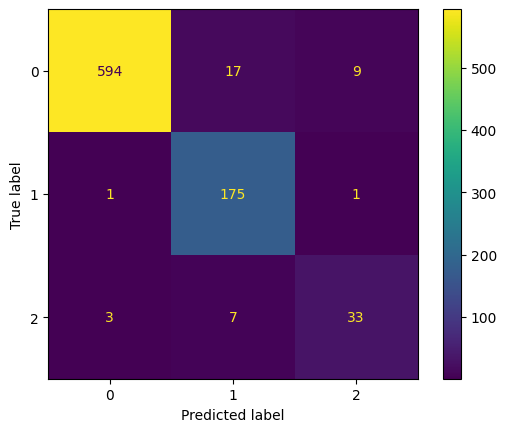

840
0.969047619047619


In [44]:
cm = sklearn.metrics.confusion_matrix(y_true, y_pred)

disp = sklearn.metrics.ConfusionMatrixDisplay(cm)

disp.plot()

plt.savefig('confusion_matrix.png')
plt.show()

wrong = 17+1+1+7
print(len(y_pred))
print((len(y_pred)-wrong)/len(y_pred))

IndexError: index 16 is out of bounds for axis 0 with size 16

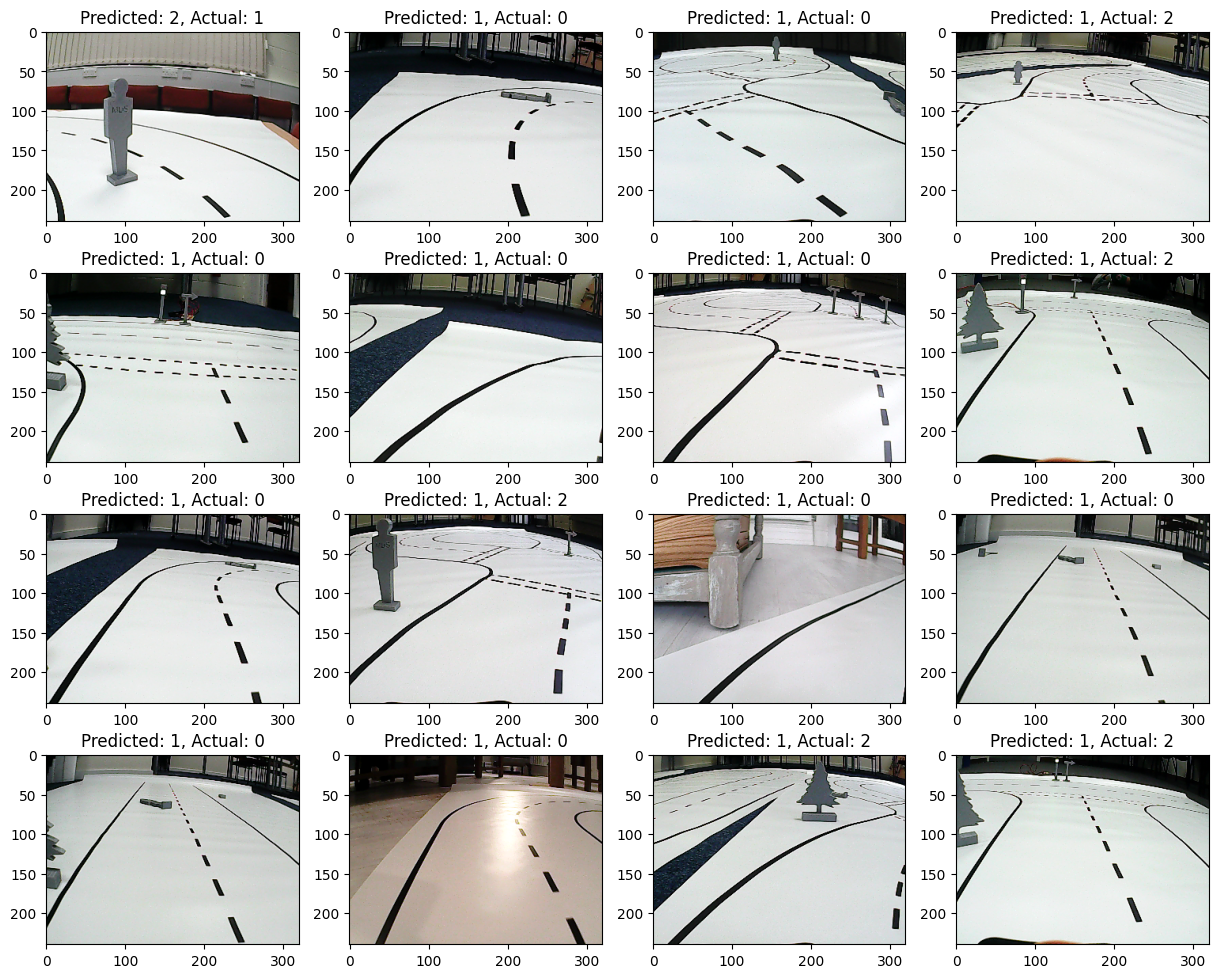

In [43]:
img_id = []
predicted = []
actual = []
count = 0
for i in range(len(y_pred)):
    if y_true[i] != y_pred[i]:
        if y_true[i] == 1 or y_pred[i] == 1:
            img_id.append(test_index[i])
            predicted.append(y_pred[i])
            actual.append(y_true[i])

fig, ax = plt.subplots(4, 4, figsize=(15, 12))
ax = ax.ravel()
for i in range(len(img_id)):
    png_path = f"{training_data_dir}/{img_id[i]}.png"
    img = plt.imread(png_path)
    ax[i].imshow(img)
    ax[i].set_title(f"Predicted: {predicted[i]}, Actual: {actual[i]}")